In [1]:
import argparse
import random
import copy
import glob
import os
import sys
from pathlib import Path

import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import tqdm
import yaml
from torch import nn

import matplotlib.pyplot as plt

## Vanilla Transformer Encoder for the backbone

In [2]:
# class for transformer network
class Transformer(nn.Module):
    # define and intialize the structure of the neural network
    def __init__(
        self,
        input_dim=3,
        model_dim=32,
        output_dim=32,
        n_heads=4,
        dim_feedforward=32,
        n_layers=4,
        learning_rate=0.00005,
        n_head_layers=2,
        head_norm=False,
        dropout=0.1,
        opt="adam",
    ):
        super().__init__()
        # define hyperparameters
        self.input_dim = input_dim
        self.model_dim = model_dim
        self.output_dim = output_dim
        self.n_heads = n_heads
        self.dim_feedforward = dim_feedforward
        self.n_layers = n_layers
        self.learning_rate = learning_rate
        self.n_head_layers = n_head_layers
        self.head_norm = head_norm
        self.dropout = dropout
        # define subnetworks
        self.embedding = nn.Linear(input_dim, model_dim)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                model_dim, n_heads, dim_feedforward=dim_feedforward, dropout=dropout
            ),
            n_layers,
        )
        # head_layers have output_dim
        if n_head_layers == 0:
            self.head_layers = []
        else:
            if head_norm:
                self.norm_layers = nn.ModuleList([nn.LayerNorm(model_dim)])
            self.head_layers = nn.ModuleList([nn.Linear(model_dim, output_dim)])
            for i in range(n_head_layers - 1):
                if head_norm:
                    self.norm_layers.append(nn.LayerNorm(output_dim))
                self.head_layers.append(nn.Linear(output_dim, output_dim))
        # option to use adam or sgd
        if opt == "adam":
            self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        if opt == "sgdca" or opt == "sgdslr" or opt == "sgd":
            self.optimizer = torch.optim.SGD(
                self.parameters(), lr=self.learning_rate, momentum=0.9
            )

    def forward(
        self,
        inpt,
        mask=None,
        use_mask=False,
        use_continuous_mask=False,
        mult_reps=False,
    ):
        """
        input here is (batch_size, n_constit, 3)
        but transformer expects (n_constit, batch_size, 3) so we need to transpose
        if use_mask is True, will mask out all inputs with pT=0
        """
        assert not (use_mask and use_continuous_mask)
        # make a copy
        x = inpt + 0.0
        # (batch_size, n_constit)
        if use_mask:
            pT_zero = x[:, :, 0] == 0
        # (batch_size, n_constit)
        if use_continuous_mask:
            pT = x[:, :, 0]
        if use_mask:
            mask = self.make_mask(pT_zero).to(x.device)
        elif use_continuous_mask:
            mask = self.make_continuous_mask(pT).to(x.device)
        else:
            mask = None
        x = torch.transpose(x, 0, 1)
        # (n_constit, batch_size, model_dim)
        x = self.embedding(x)
        x = self.transformer(x, mask=mask)
        if use_mask:
            # set masked constituents to zero
            # otherwise the sum will change if the constituents with 0 pT change
            x[torch.transpose(pT_zero, 0, 1)] = 0
        elif use_continuous_mask:
            # scale x by pT, so that function is IR safe
            # transpose first to get correct shape
            x *= torch.transpose(pT, 0, 1)[:, :, None]
        # sum over sequence dim
        # (batch_size, model_dim)
        x = x.sum(0)
        return self.head(x, mult_reps)

    def head(self, x, mult_reps):
        """
        calculates output of the head if it exists, i.e. if n_head_layer>0
        returns multiple representation layers if asked for by mult_reps = True
        input:  x shape=(batchsize, model_dim)
                mult_reps boolean
        output: reps shape=(batchsize, output_dim)                  for mult_reps=False
                reps shape=(batchsize, number_of_reps, output_dim)  for mult_reps=True
        """
        relu = nn.ReLU()
        # return representations from multiple layers for evaluation
        if mult_reps == True:
            if self.n_head_layers > 0:
                reps = torch.empty(x.shape[0], self.n_head_layers + 1, self.output_dim)
                reps[:, 0] = x
                for i, layer in enumerate(self.head_layers):
                    # only apply layer norm on head if chosen
                    if self.head_norm:
                        x = self.norm_layers[i](x)
                    x = relu(x)
                    x = layer(x)
                    reps[:, i + 1] = x
                # shape (n_head_layers, output_dim)
                return reps
            # no head exists -> just return x in a list with dimension 1
            else:
                reps = x[:, None, :]
                # shape (batchsize, 1, model_dim)
                return reps
        # return only last representation for contrastive loss
        else:
            for i, layer in enumerate(
                self.head_layers
            ):  # will do nothing if n_head_layers is 0
                if self.head_norm:
                    x = self.norm_layers[i](x)
                x = relu(x)
                x = layer(x)
            # shape either (model_dim) if no head, or (output_dim) if head exists
            return x

    def forward_batchwise(
        self, x, batch_size, use_mask=False, use_continuous_mask=False
    ):
        device = next(self.parameters()).device
        with torch.no_grad():
            if self.n_head_layers == 0:
                rep_dim = self.model_dim
                number_of_reps = 1
            elif self.n_head_layers > 0:
                rep_dim = self.output_dim
                number_of_reps = self.n_head_layers + 1
            out = torch.empty(x.size(0), number_of_reps, rep_dim)
            idx_list = torch.split(torch.arange(x.size(0)), batch_size)
            for idx in idx_list:
                output = (
                    self(
                        x[idx].to(device),
                        use_mask=use_mask,
                        use_continuous_mask=use_continuous_mask,
                        mult_reps=True,
                    )
                    .detach()
                    .cpu()
                )
                out[idx] = output
        return out

    def make_mask(self, pT_zero):
        """
        Input: batch of bools of whether pT=0, shape (batchsize, n_constit)
        Output: mask for transformer model which masks out constituents with pT=0, shape (batchsize*n_transformer_heads, n_constit, n_constit)
        mask is added to attention output before softmax: 0 means value is unchanged, -inf means it will be masked
        """
        n_constit = pT_zero.size(1)
        pT_zero = torch.repeat_interleave(pT_zero, self.n_heads, axis=0)
        pT_zero = torch.repeat_interleave(pT_zero[:, None], n_constit, axis=1)
        mask = torch.zeros(pT_zero.size(0), n_constit, n_constit)
        mask[pT_zero] = -np.inf
        return mask

    def make_continuous_mask(self, pT):
        """
        Input: batch of pT values, shape (batchsize, n_constit)
        Output: mask for transformer model: -1/pT, shape (batchsize*n_transformer_heads, n_constit, n_constit)
        mask is added to attention output before softmax: 0 means value is unchanged, -inf means it will be masked
        intermediate values mean it is partly masked
        This function implements IR safety in the transformer
        """
        n_constit = pT.size(1)
        pT_reshape = torch.repeat_interleave(pT, self.n_heads, axis=0)
        pT_reshape = torch.repeat_interleave(pT_reshape[:, None], n_constit, axis=1)
        # mask = -1/pT_reshape
        mask = 0.5 * torch.log(pT_reshape)
        return mask

## Define data augmentations

In [3]:
def rotate_jets(batch, device):
    """
    Input: batch of jets, shape (batchsize, 3, n_constit)
    dim 1 ordering: (pT, eta, phi)
    Output: batch of jets rotated independently in eta-phi, same shape as input
    """
    rot_angle = torch.rand(batch.shape[0]) * 2 * torch.tensor(np.pi)
    c = torch.cos(rot_angle)
    s = torch.sin(rot_angle)
    o = torch.ones_like(rot_angle)
    z = torch.zeros_like(rot_angle)
    rot_matrix = (
        torch.stack([o, z, z, z, c, -s, z, s, c], dim=1)
        .reshape(-1, 3, 3)
        .transpose(0, 2)
    ).to(
        device
    )  # (batchsize, 3, 3)
    return torch.einsum("ijk,lji->ilk", batch, rot_matrix)

def augmentation(args, x, device):
    """
    Applies all the augmentations specified in the args
    """
    # cropping to 50 particles is already done in data preprocessing
    y = x.clone()
    x = rotate_jets(x, device)
    
    x = x.transpose(1, 2)  # [batch_size, 3, n_constit] -> [batch_size, n_constit, 3]
    y = y.transpose(1, 2)  # [batch_size, 3, n_constit] -> [batch_size, n_constit, 3]
    
    return x, y

## The VICReg model

In [4]:
class VICReg(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.num_features = int(
            args.mlp.split("-")[-1]
        )  # size of the last layer of the MLP projector
        self.x_transform = nn.Sequential(
            nn.BatchNorm1d(args.x_inputs),
            nn.Linear(args.x_inputs, args.transform_inputs),
            nn.BatchNorm1d(args.transform_inputs),
            nn.ReLU(),
        )
        self.y_transform = nn.Sequential(
            nn.BatchNorm1d(args.y_inputs),
            nn.Linear(args.y_inputs, args.transform_inputs),
            nn.BatchNorm1d(args.transform_inputs),
            nn.ReLU(),
        )
        self.augmentation = args.augmentation
        self.x_backbone = args.x_backbone
        self.y_backbone = args.y_backbone
        self.N_x = self.x_backbone.input_dim
        self.N_y = self.y_backbone.input_dim
        self.embedding = args.Do
        self.return_embedding = args.return_embedding
        self.return_representation = args.return_representation
        self.x_projector = Projector(args.mlp, self.embedding)
        self.y_projector = (
            self.x_projector if args.shared else copy.deepcopy(self.x_projector)
        )

    def forward(self, x):
        """
        x -> x_aug -> (x_xform) -> x_rep -> x_emb
        y -> y_aug -> (y_xform) -> y_rep -> y_emb
        _aug: augmented
        _xform: transformed by linear layer (skipped because it destroys the zero padding)
        _rep: backbone representation
        _emb: projected embedding
        """
        x_aug, y_aug = self.augmentation(
            self.args, x, self.args.device
        )  # [batch_size, n_constit, 3]

        x_rep = self.x_backbone(
            x_aug, use_mask=self.args.mask, use_continuous_mask=self.args.cmask
        )  # [batch_size, output_dim]
        y_rep = self.y_backbone(
            y_aug, use_mask=self.args.mask, use_continuous_mask=self.args.cmask
        )  # [batch_size, output_dim]
        if self.return_representation:
            return x_rep, y_rep

        x_emb = self.x_projector(x_rep)  # [batch_size, embedding_size]
        y_emb = self.y_projector(y_rep)  # [batch_size, embedding_size]
        if self.return_embedding:
            return x_emb, y_emb
        x = x_emb
        y = y_emb
        repr_loss = F.mse_loss(x, y)

        x = x - x.mean(dim=0)
        y = y - y.mean(dim=0)

        std_x = torch.sqrt(x.var(dim=0) + 0.0001)
        std_y = torch.sqrt(y.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        cov_x = (x.T @ x) / (self.args.batch_size - 1)
        cov_y = (y.T @ y) / (self.args.batch_size - 1)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(
            self.num_features
        ) + off_diagonal(cov_y).pow_(2).sum().div(self.num_features)

        loss = (
            self.args.sim_coeff * repr_loss
            + self.args.std_coeff * std_loss
            + self.args.cov_coeff * cov_loss
        )
        if args.return_all_losses:
            return loss, repr_loss, std_loss, cov_loss
        else:
            return loss

In [5]:
def Projector(mlp, embedding):
    mlp_spec = f"{embedding}-{mlp}"
    layers = []
    f = list(map(int, mlp_spec.split("-")))
    for i in range(len(f) - 2):
        layers.append(nn.Linear(f[i], f[i + 1]))
        layers.append(nn.BatchNorm1d(f[i + 1]))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(f[-2], f[-1], bias=False))
    return nn.Sequential(*layers)


def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()


def get_backbones(args):
    x_backbone = Transformer(input_dim=args.x_inputs)
    y_backbone = x_backbone if args.shared else copy.deepcopy(x_backbone)
    return x_backbone, y_backbone

In [6]:
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])

In [7]:
args.mask = False
args.cmask = True
args.epoch = 10
args.batch_size = 256
args.label = "notebook_test"
args.num_train_files = 1
args.num_val_files = 1
args.shared = False
args.mlp = "256-256-256"
args.transform_inputs = 32
args.Do = 32
args.hidden = 128
args.sim_coeff = 25.0
args.std_coeff = 25.0
args.cov_coeff = 1.0
args.return_embedding = False
args.return_representation = False
args.do_translation = True
args.do_rotation = True
args.do_cf = True
args.do_ptd = True
args.nconstit = 50
args.ptst = 0.1
args.ptcm = 0.1
args.trsw = 1.0
args.return_all_losses = True

In [8]:
# define the global base device
world_size = torch.cuda.device_count()
if world_size:
    device = torch.device("cuda:0")
    for i in range(world_size):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    device = "cpu"
    print("Device: CPU")
args.device = device

Device 0: NVIDIA GeForce GTX 1080 Ti


## Load a sample data file

In [9]:
! wget https://ssl-jet-v2.nrp-nautilus.io/toptagging/train/processed/3_features/data_0.pt

--2023-10-31 18:21:39--  https://ssl-jet-v2.nrp-nautilus.io/toptagging/train/processed/3_features/data_0.pt
Resolving ssl-jet-v2.nrp-nautilus.io (ssl-jet-v2.nrp-nautilus.io)... 198.32.43.49, 2605:d9c0:2:10::3:2
Connecting to ssl-jet-v2.nrp-nautilus.io (ssl-jet-v2.nrp-nautilus.io)|198.32.43.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60001323 (57M) [application/vnd.snesdev-page-table]
Saving to: ‘data_0.pt.1’

data_0.pt.1         100%[===================>]  57.22M  71.0MB/s    in 0.8s    

2023-10-31 18:21:40 (71.0 MB/s) - ‘data_0.pt.1’ saved [60001323/60001323]



In [10]:
n_epochs = args.epoch
batch_size = args.batch_size
label = args.label

# prepare data
data = torch.load("data_0.pt")
data_train = data[:int(data.shape[0] * 0.8)]
data_valid = data[int(data.shape[0] * 0.8):]

n_train = len(data_train)
n_val = len(data_valid)

In [11]:
args.augmentation = augmentation

args.x_inputs = 3
args.y_inputs = 3

args.x_backbone, args.y_backbone = get_backbones(args)
model = VICReg(args).to(args.device)
print(model)

train_its = int(n_train / batch_size)
val_its = int(n_val / batch_size)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_val_epochs = []  # loss recorded for each epoch
repr_loss_val_epochs, std_loss_val_epochs, cov_loss_val_epochs = [], [], []
# invariance, variance, covariance loss recorded for each epoch
loss_val_batches = []  # loss recorded for each batch
loss_train_epochs = []  # loss recorded for each epoch
repr_loss_train_epochs, std_loss_train_epochs, cov_loss_train_epochs = [], [], []
# invariance, variance, covariance loss recorded for each epoch
loss_train_batches = []  # loss recorded for each batch
l_val_best = 999999
for m in range(n_epochs):
    print(f"Epoch {m}\n")
    loss_train_epoch = []  # loss recorded for each batch in this epoch
    repr_loss_train_epoch, std_loss_train_epoch, cov_loss_train_epoch = [], [], []
    # invariance, variance, covariance loss recorded for each batch in this epoch
    loss_val_epoch = []  # loss recorded for each batch in this epoch
    repr_loss_val_epoch, std_loss_val_epoch, cov_loss_val_epoch = [], [], []
    # invariance, variance, covariance loss recorded for each batch in this epoch

    train_loader = DataLoader(data_train, batch_size)
    model.train()
    pbar = tqdm.tqdm(train_loader, total=train_its)
    for _, batch in enumerate(pbar):
        batch = batch.to(args.device)
        optimizer.zero_grad()
        if args.return_all_losses:
            loss, repr_loss, std_loss, cov_loss = model.forward(batch)
#             print(loss, repr_loss, std_loss, cov_loss)
            repr_loss_train_epoch.append(repr_loss.detach().cpu().item())
            std_loss_train_epoch.append(std_loss.detach().cpu().item())
            cov_loss_train_epoch.append(cov_loss.detach().cpu().item())
        else:
            loss = model.forward(batch)
        loss.backward()
        optimizer.step()
        loss = loss.detach().cpu().item()
        loss_train_batches.append(loss)
        loss_train_epoch.append(loss)
        pbar.set_description(f"Training loss: {loss:.4f}")
    model.eval()
    valid_loader = DataLoader(data_valid, batch_size)
    pbar = tqdm.tqdm(valid_loader, total=val_its)
    for _, batch in enumerate(pbar):
        batch = batch.to(args.device)
        if args.return_all_losses:
            loss, repr_loss, std_loss, cov_loss = model.forward(batch)
            repr_loss_val_epoch.append(repr_loss.detach().cpu().item())
            std_loss_val_epoch.append(std_loss.detach().cpu().item())
            cov_loss_val_epoch.append(cov_loss.detach().cpu().item())
            loss = loss.detach().cpu().item()
        else:
            loss = model.forward(batch).cpu().item()
        loss_val_batches.append(loss)
        loss_val_epoch.append(loss)
        pbar.set_description(f"Validation loss: {loss:.4f}")
    l_val = np.mean(np.array(loss_val_epoch))
    l_train = np.mean(np.array(loss_train_epoch))
    loss_val_epochs.append(l_val)
    loss_train_epochs.append(l_train)

    if args.return_all_losses:
        repr_l_val = np.mean(np.array(repr_loss_val_epoch))
        repr_l_train = np.mean(np.array(repr_loss_train_epoch))
        std_l_val = np.mean(np.array(std_loss_val_epoch))
        std_l_train = np.mean(np.array(std_loss_train_epoch))
        cov_l_val = np.mean(np.array(cov_loss_val_epoch))
        cov_l_train = np.mean(np.array(cov_loss_train_epoch))

        repr_loss_val_epochs.append(repr_l_val)
        std_loss_val_epochs.append(std_l_val)
        cov_loss_val_epochs.append(cov_l_val)

        repr_loss_train_epochs.append(repr_l_train)
        std_loss_train_epochs.append(std_l_train)
        cov_loss_train_epochs.append(cov_l_train)
    # save the model
    if l_val < l_val_best:
        print("New best model")
        l_val_best = l_val
        torch.save(model.state_dict(), f"vicreg_{label}_best.pth")
    torch.save(model.state_dict(), f"vicreg_{label}_last.pth")

VICReg(
  (x_transform): Sequential(
    (0): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=3, out_features=32, bias=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (y_transform): Sequential(
    (0): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=3, out_features=32, bias=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (x_backbone): Transformer(
    (embedding): Linear(in_features=3, out_features=32, bias=True)
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
          )
          (linear1): Linear(in_features=32, out_features=32, bias=

Training loss: 13.5863: : 313it [00:13, 22.69it/s]                                                                                                                                           
Validation loss: 10.7390: : 79it [00:01, 71.28it/s]                                                                                                                                          


New best model
Epoch 1



Training loss: 11.5776: : 313it [00:13, 23.16it/s]                                                                                                                                           
Validation loss: 9.1748: : 79it [00:01, 71.72it/s]                                                                                                                                           


New best model
Epoch 2



Training loss: 10.6266: : 313it [00:13, 23.19it/s]                                                                                                                                           
Validation loss: 8.4299: : 79it [00:01, 71.80it/s]                                                                                                                                           


New best model
Epoch 3



Training loss: 9.9119: : 313it [00:13, 23.47it/s]                                                                                                                                            
Validation loss: 7.2364: : 79it [00:01, 70.60it/s]                                                                                                                                           


New best model
Epoch 4



Training loss: 9.1560: : 313it [00:13, 23.30it/s]                                                                                                                                            
Validation loss: 6.2524: : 79it [00:01, 69.17it/s]                                                                                                                                           


New best model
Epoch 5



Training loss: 8.6258: : 313it [00:13, 23.50it/s]                                                                                                                                            
Validation loss: 5.7239: : 79it [00:01, 71.59it/s]                                                                                                                                           


New best model
Epoch 6



Training loss: 8.1174: : 313it [00:13, 23.71it/s]                                                                                                                                            
Validation loss: 5.8311: : 79it [00:01, 72.08it/s]                                                                                                                                           


New best model
Epoch 7



Training loss: 7.6427: : 313it [00:13, 23.83it/s]                                                                                                                                            
Validation loss: 5.1740: : 79it [00:01, 71.50it/s]                                                                                                                                           


New best model
Epoch 8



Training loss: 7.3339: : 313it [00:13, 23.20it/s]                                                                                                                                            
Validation loss: 4.9468: : 79it [00:01, 71.75it/s]                                                                                                                                           


New best model
Epoch 9



Training loss: 7.1468: : 313it [00:13, 23.13it/s]                                                                                                                                            
Validation loss: 4.7498: : 79it [00:01, 71.54it/s]                                                                                                                                           


New best model


## See the performance

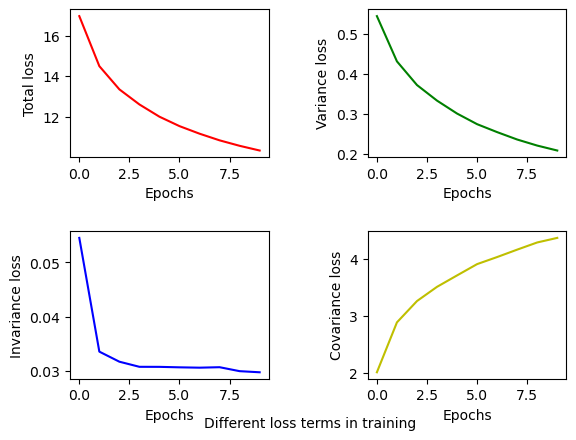

In [12]:
fontsize = 10
fig, ax = plt.subplots(2, 2)

ax[0, 0].plot(loss_train_epochs, 'r') #row=0, col=0
ax[0, 0].set_xlabel("Epochs", fontsize=fontsize)
ax[0, 0].set_ylabel("Total loss", fontsize=fontsize)


ax[1,0].plot(repr_loss_train_epochs, 'b') #row=1, col=0
ax[1,0].set_xlabel("Epochs", fontsize=fontsize)
ax[1,0].set_ylabel("Invariance loss", fontsize=fontsize)

ax[0,1].plot(std_loss_train_epochs, 'g') #row=0, col=1
ax[0,1].set_xlabel("Epochs", fontsize=fontsize)
ax[0,1].set_ylabel("Variance loss", fontsize=fontsize)


ax[1,1].plot(cov_loss_train_epochs, 'y') #row=1, col=1
ax[1,1].set_xlabel("Epochs", fontsize=fontsize)
ax[1,1].set_ylabel("Covariance loss", fontsize=fontsize)

plt.subplots_adjust(hspace=0.5, wspace=0.5) # adjust spacing between plots
plt.figtext(0.5, 0.01, "Different loss terms in training", ha="center", fontsize=10)
plt.show()


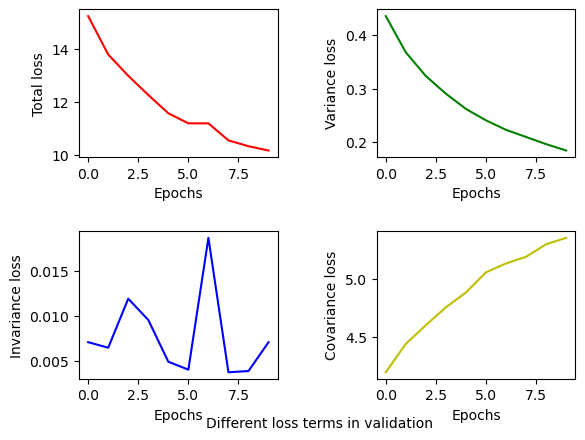

In [13]:
fontsize = 10
fig, ax = plt.subplots(2, 2)

ax[0, 0].plot(loss_val_epochs, 'r') #row=0, col=0
ax[0, 0].set_xlabel("Epochs", fontsize=fontsize)
ax[0, 0].set_ylabel("Total loss", fontsize=fontsize)


ax[1,0].plot(repr_loss_val_epochs, 'b') #row=1, col=0
ax[1,0].set_xlabel("Epochs", fontsize=fontsize)
ax[1,0].set_ylabel("Invariance loss", fontsize=fontsize)

ax[0,1].plot(std_loss_val_epochs, 'g') #row=0, col=1
ax[0,1].set_xlabel("Epochs", fontsize=fontsize)
ax[0,1].set_ylabel("Variance loss", fontsize=fontsize)


ax[1,1].plot(cov_loss_val_epochs, 'y') #row=1, col=1
ax[1,1].set_xlabel("Epochs", fontsize=fontsize)
ax[1,1].set_ylabel("Covariance loss", fontsize=fontsize)

plt.subplots_adjust(hspace=0.5, wspace=0.5) # adjust spacing between plots
plt.figtext(0.5, 0.01, "Different loss terms in validation", ha="center", fontsize=10)
plt.show()
